In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky, cho_solve
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from sklearn.datasets import load_iris, make_regression, load_digits
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Tuple, List

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## **PART A**

In [3]:
class GaussianProcessRegression:
    """
        Gaussian Process Regression model with RBF Kernel
        The GP is defined as: f ~ GP(mu(x), k(x, x')) where k is the RBF kernel
        For regression: y = f(x) + eps, eps ~ N(0, beta^(-1))
    """
    def __init__(self, length_scale: float = 1.0, signal_variance: float = 1.0, noise_variance: float = 0.1):
        """
            Initialize GP with hyperparameters.
            Args:
                length_scale: Length scale parameter of the RBF kernel.
                signal_variance: Signal variance parameter of the RBF kernel.
                noise_variance: Noise variance (beta^(-1)) of the observations.
        """
        self.length_scale = length_scale
        self.signal_variance = signal_variance
        self.noise_variance = noise_variance
        
        # For training data
        self.X_train = None
        self.y_train = None
        self.K_inv = None       # Inverse of CoV Matrix
        
    def rbf_kernel(self, X1: np.ndarray, X2: np.ndarray) -> np.ndarray:
        """
            RBF kernel function.
            Args:
                X1: First input data of shape (N1, D).
                X2: Second input data of shape (N2, D).
            Returns:
                Kernel matrix of shape (N1, N2).
                
            Formula used: k(x, x') = signal_variance * exp(-||x - x'||^2 / (2 * length_scale^2))
        """
        X1_sq = np.sum(X1**2, axis=1, keepdims=True)
        X2_sq = np.sum(X2**2, axis=1, keepdims=True)
        distances_sq = X1_sq + X2_sq.T - 2 * X1 @ X2.T
        K = self.signal_variance * np.exp(-distances_sq / (2 * self.length_scale**2))
        return K
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        """
            Fit the GP to training data.
            Args:
                X: Training input data of shape (N, D).
                y: Training target data of shape (N,).
        """
        self.X_train = X
        self.y_train = y
        
        # CoV Matrix - C_N = K + noise_variance * I, where K is the kernel matrix, calculated from the function above
        K = self.rbf_kernel(X, X)
        C_N = K + self.noise_variance * np.eye(len(X))
        
        # Store inverse for predictions (using cholesky for numerical stability)
        L = cholesky(C_N, lower=True)
        self.L = L
        self.alpha = cho_solve((L, True), y)    # alpha = C_N^(-1) * y
        
    def predict(self, X_test: np.ndarray, return_std: bool = True) -> Tuple:
        """
            Predict at test points using the GP posterior.
            Args:
                X_test: Test input data of shape (M, D).
                return_std: Whether to return standard deviation of predictions.
            Returns:
                mean: Predictive mean of shape (M,).
                std: Predictive standard deviation of shape (M,) if return_std is True.
            Formula used for prediction: p(y* | y) = N(y* | k_star.T @ C_N^(-1) @ y, k(x*, x*) - k_star.T @ C_N^(-1) @ k_star + noise_variance) {Formula directly from the notes}
        """
        k_star = self.rbf_kernel(self.X_train, X_test)
        mean = k_star.T @ self.alpha
        if return_std:
            k_star_star = self.signal_variance
            v = cho_solve((self.L, True), k_star)
            variance = k_star_star - np.sum(k_star * v, axis=0) + self.noise_variance
            std = np.sqrt(np.maximum(variance, 0))
            return mean, std
        return mean
    
    def log_marginal_likelihood(self) -> float:
        """
            Compute the log marginal likelihood (evidence) of the training data.
            Returns:
                log_marginal_likelihood: The log marginal likelihood value.
            Formula used: logp(y | X) = -0.5 * y.T @ C_N^(-1) @ y - 0.5 * log|C_N| - (N/2) * log(2*pi)
        """
        N = len(self.y_train)
        data_fit = -0.5 * self.y_train.T @ self.alpha
        complexity = -np.sum(np.log(np.diag(self.L)))
        constant = -0.5 * N * np.log(2 * np.pi)
        return data_fit + complexity + constant
    
    def optimize_hyperparameters(self, X: np.ndarray, y: np.ndarray):
        """
            Optimize the hyperparameters by maximizing the log marginal likelihood.
            Args:
                X: Training input data of shape (N, D).
                y: Training target data of shape (N,).
            Returns:
                result: The optimization result returned by scipy.optimize.minimize.
        """
        def objective(params):
            self.length_scale = np.exp(params[0])
            self.signal_variance = np.exp(params[1])
            self.noise_variance = np.exp(params[2])
            try:
                self.fit(X, y)
                return -self.log_marginal_likelihood()
            except np.linalg.LinAlgError:
                return 1e10
            
        init_params = np.log([self.length_scale, self.signal_variance, self.noise_variance])
        result = minimize(objective, init_params, method='L-BFGS-B')
        opt_params = result.x
        self.length_scale = np.exp(opt_params[0])
        self.signal_variance = np.exp(opt_params[1])
        self.noise_variance = np.exp(opt_params[2])
        self.fit(X, y)
        return result

In [4]:
def partA():
    print("===== PART A.1 =====")
    np.random.seed(42)
    X_range = np.linspace(0, 2*np.pi, 100).reshape(-1, 1)
    
    # Function to generate data (as given in the question)
    def true_function(x):
        return np.sin(3*x) + 0.5 * np.cos(5*x)
    
    n_train = 100
    X_train = np.random.uniform(0, 2*np.pi, n_train).reshape(-1, 1)
    y_train = true_function(X_train).ravel() + np.random.normal(0, 0.2, n_train)
    
    gp = GaussianProcessRegression(length_scale=0.5, signal_variance=1.0, noise_variance=0.04)
    gp.fit(X_train, y_train)
    y_pred, y_std = gp.predict(X_range, return_std=True)
    
    plt.figure(figsize=(8, 4))
    plt.plot(X_range, true_function(X_range), 'g--', label='True function', linewidth=2)
    plt.scatter(X_train, y_train, c='red', s=50, label='Training data', zorder=5)
    plt.plot(X_range, y_pred, 'b-', label='GP mean', linewidth=2)
    plt.fill_between(X_range.ravel(), 
                     y_pred - 1.96*y_std, 
                     y_pred + 1.96*y_std,
                     alpha=0.3, label='95% credible interval')
    plt.xlabel('x', fontsize=12)
    plt.ylabel('f(x)', fontsize=12)
    plt.title('Gaussian Process Regression with RBF Kernel', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('gp_regression_part_a1.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Initial hyperparameters:")
    print(f"  Length scale (l): {gp.length_scale:.4f}")
    print(f"  Signal variance (sigma^2): {gp.signal_variance:.4f}")
    print(f"  Noise variance (beta^(-1)): {gp.noise_variance:.4f}")
    print(f"  Log marginal likelihood: {gp.log_marginal_likelihood():.4f}")
    print()
    
    print("===== PART A.2 =====")
    np.random.seed(42)
    X_range = np.linspace(0, 2*np.pi, 100).reshape(-1, 1)
    
    def true_function(x):
        return np.sin(3*x) + 0.5 * np.cos(5*x)
    
    n_train = 100
    X_train = np.random.uniform(0, 2*np.pi, n_train).reshape(-1, 1)
    y_train = true_function(X_train).ravel() + np.random.normal(0, 0.2, n_train)
    
    gp_before = GaussianProcessRegression(length_scale=0.3, signal_variance=0.5, noise_variance=0.1)
    gp_before.fit(X_train, y_train)
    y_pred_before, y_std_before = gp_before.predict(X_range, return_std=True)
    print("BEFORE optimization:")
    print(f"  Length scale (l): {gp_before.length_scale:.4f}")
    print(f"  Signal variance (sigma^2): {gp_before.signal_variance:.4f}")
    print(f"  Noise variance (beta^(-1)): {gp_before.noise_variance:.4f}")
    print(f"  Log marginal likelihood: {gp_before.log_marginal_likelihood():.4f}")
    print()
    
    gp_after = GaussianProcessRegression(length_scale=0.3, signal_variance=0.5, noise_variance=0.1)
    result = gp_after.optimize_hyperparameters(X_train, y_train)
    y_pred_after, y_std_after = gp_after.predict(X_range, return_std=True)
    print("AFTER optimization:")
    print(f"  Length scale (l): {gp_after.length_scale:.4f}")
    print(f"  Signal variance (sigma^2): {gp_after.signal_variance:.4f}")
    print(f"  Noise variance (beta^(-1)): {gp_after.noise_variance:.4f}")
    print(f"  Log marginal likelihood: {gp_after.log_marginal_likelihood():.4f}")
    print(f"  Optimization success: {result.success}")
    print()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for ax, y_pred, y_std, title, gp in zip(
            axes, 
            [y_pred_before, y_pred_after],
            [y_std_before, y_std_after],
            ['Before Optimization', 'After Optimization'],
            [gp_before, gp_after]):
        
        ax.plot(X_range, true_function(X_range), 'g--', label='True function', linewidth=2)
        ax.scatter(X_train, y_train, c='red', s=50, label='Training data', zorder=5)
        ax.plot(X_range, y_pred, 'b-', label='GP mean', linewidth=2)
        ax.fill_between(X_range.ravel(), 
                       y_pred - 1.96*y_std, 
                       y_pred + 1.96*y_std,
                       alpha=0.3, label='95% credible interval')
        
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('f(x)', fontsize=12)
        ax.set_title(f'{title}\n l={gp.length_scale:.3f}, sigma^2={gp.signal_variance:.3f}, beta^(-1)={gp.noise_variance:.3f}',
                    fontsize=12)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('gp_optimization_part_a2.jpg', dpi=300, bbox_inches='tight')
    plt.show()

===== PART A.1 =====


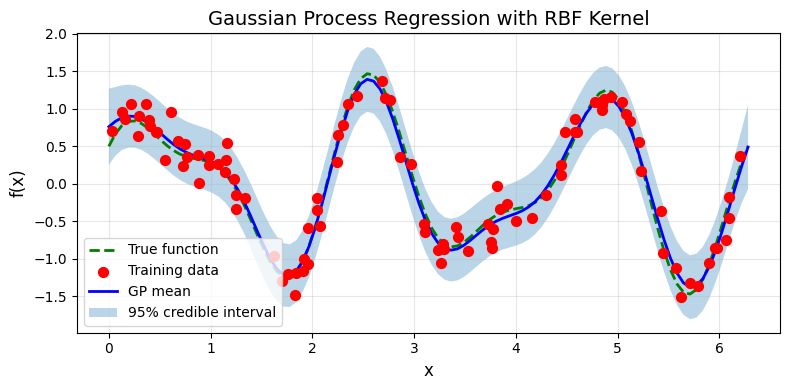

Initial hyperparameters:
  Length scale (l): 0.5000
  Signal variance (sigma^2): 1.0000
  Noise variance (beta^(-1)): 0.0400
  Log marginal likelihood: -8.8592

===== PART A.2 =====
BEFORE optimization:
  Length scale (l): 0.3000
  Signal variance (sigma^2): 0.5000
  Noise variance (beta^(-1)): 0.1000
  Log marginal likelihood: -27.8586

AFTER optimization:
  Length scale (l): 0.4557
  Signal variance (sigma^2): 1.0484
  Noise variance (beta^(-1)): 0.0335
  Log marginal likelihood: -7.3491
  Optimization success: True



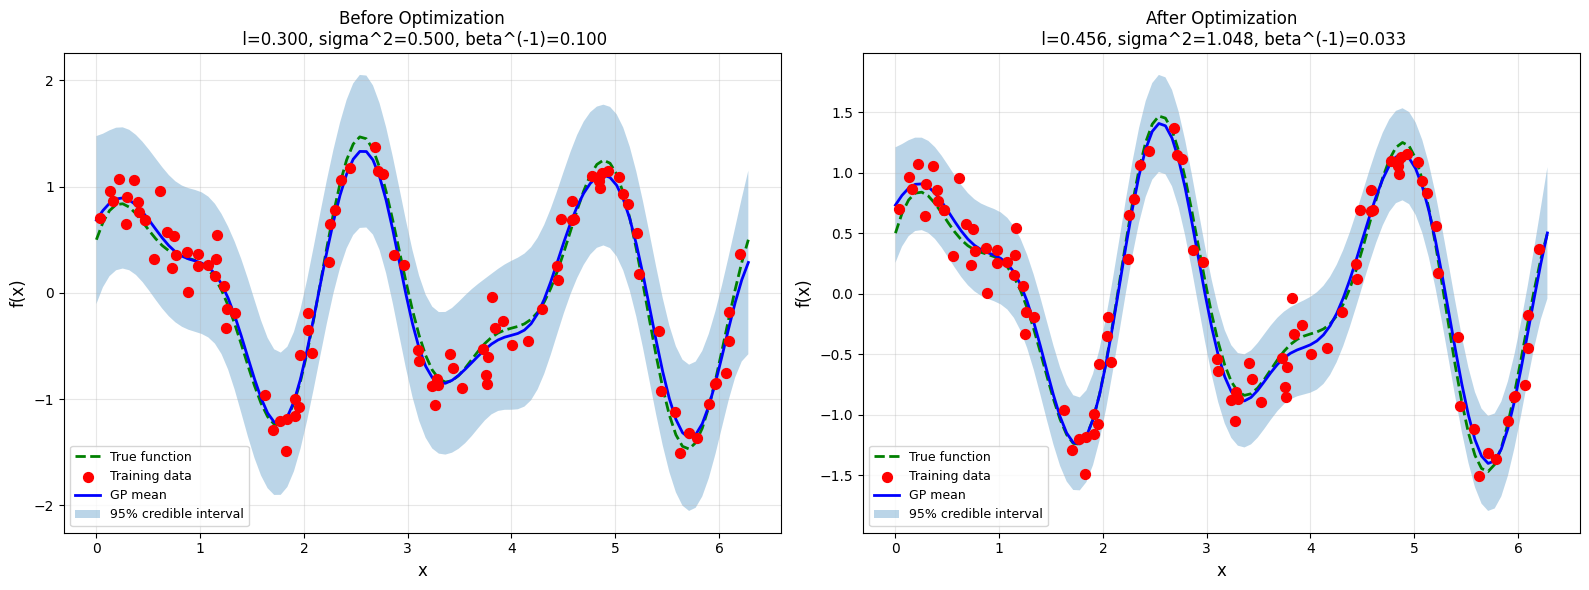

In [5]:
partA()

## **PART B**

In [ ]:
class GaussianMixtureModel:
    """
        Gaussian Mixture Model using the EM Algorithm
        Model: x_n ~ sum_k pi_k * N(x_n | mu_k, Sigma_k)
        Latent Variable - z_n ~ {1, 2, ..., K} indicates which component generated x_n
    """
    def __init__(self, n_components: int, max_iter: int = 100, tol: float = 1e-4):
        """
            Initialize GMM with number of components and EM parameters
            Args:
                n_components: Number of mixture components (K).
                max_iter: Maximum number of EM iterations.
                tol: Convergence tolerance for log likelihood change.
        """
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        
        self.pi = None
        self.mu = None
        self.Sigma = None
        
        self.log_likelihoods = []
        
    def initialize_parameters(self, X: np.ndarray):
        """
            Initialize GMM parameters using K-means, in a hope to give a better starting point for EM than random initialization
            Args:
                X: Input data of shape (N, D).
        """
        N, D = X.shape
        kmeans = KMeans(n_clusters=self.K, n_init=10, random_state=42)
        labels = kmeans.fit_predict(X)

        self.pi = np.ones(self.K) / self.K
        self.mu = kmeans.cluster_centers_
        self.Sigma = np.zeros((self.K, D, D))
        
        for k in range(self.K):
            X_k = X[labels == k]
            if len(X_k) > 0:
                self.Sigma[k] = np.cov(X_k.T) + 1e-6 * np.eye(D)
            else:
                self.Sigma[k] = np.eye(D)
                
    def e_step(self, X: np.ndarray) -> np.ndarray:
        """
            E-step: Compute posterior probabilities (responsibilities)
            Args:
                X: Input data of shape (N, D).
            Returns:
                gamma: Responsibilities of shape (N, K).
            Formula used: gamma_nk = pi_k * N(x_n | mu_k, Sigma_k) / sum_j pi_j * N(x_n | mu_j, Sigma_j)
            Also regarded as "soft clustering", where each datapoint has a certain probability of belonging to each cluster
        """
        N = len(X)
        gamma = np.zeros((N, self.K))
        
        for k in range(self.K):
            gamma[:, k] = self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=self.Sigma[k])
            
        gamma_sum = gamma.sum(axis=1, keepdims=True)
        gamma /= (gamma_sum + 1e-10)
        
        return gamma
    
    def m_step(self, X: np.ndarray, gamma: np.ndarray):
        """
            M-step: Update parameters by maximizing expected Complete Log Likelihood
            Args:
                X: Input data of shape (N, D).
                gamma: Responsibilities of shape (N, K).
            Formulae Used:
                N_k = sum_n gamma_nk
                mu_k = (1 / N_k) * sum_n gamma_nk * x_n
                Sigma_k = (1 / N_k) * sum_n gamma_nk * (x_n - mu_k)(x_n - mu_k).T
                pi_k = N_k / N
        """
        N, D = X.shape
        N_k = gamma.sum(axis=0)
        
        self.pi = N_k / N
        self.mu = (gamma.T @ X) / N_k[:, np.newaxis]
        
        for k in range(self.K):
            diff = X - self.mu[k]
            self.Sigma[k] = (gamma[:, k][:, np.newaxis] * diff).T @ diff / N_k[k]
            self.Sigma[k] += 1e-6 * np.eye(D)
            
    def compute_log_likelihood(self, X: np.ndarray) -> float:
        """
            Compute the incomplete log likelihood: log p(X | parameters)
            Args:
                X: Input data of shape (N, D).
            Returns:
                log_likelihood: The log likelihood value.
            Formula used: logp(X | parameters) = sum_n log(sum_k pi_k * N(x_n | mu_k, Sigma_k))
        """
        N = len(X)
        log_likelihood = 0.0
        
        for n in range(N):
            prob = 0
            for k in range(self.K):
                prob += self.pi[k] * multivariate_normal.pdf(X[n], mean=self.mu[k], cov=self.Sigma[k])
            log_likelihood += np.log(prob + 1e-10)
            
        return log_likelihood
    
    def fit(self, X: np.ndarray) -> 'GaussianMixtureModel':
        """
            Fit GMM using the EM algorithm.
            Args:
                X: Input data of shape (N, D).
            Returns:
                self: The fitted GMM model.
        """
        self.initialize_parameters(X)
        
        for iteration in range(self.max_iter):
            gamma = self.e_step(X)
            self.m_step(X, gamma)
            log_likelihood = self.compute_log_likelihood(X)
            self.log_likelihoods.append(log_likelihood)
            
            if iteration > 0:
                if abs(self.log_likelihoods[-1] - self.log_likelihoods[-2]) < self.tol:
                    print(f"Converged after {iteration + 1} iterations")
                    break
            if (iteration + 1) % 5 == 0:
                print(f"Iteration {iteration + 1}, Log Likelihood: {log_likelihood:.4f}")
                
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
            Predict clustering assignments (hard clustering)
            Args:
                X: Input data of shape (N, D).
            Returns:
                labels: Cluster assignments of shape (N,).
        """
        gamma = self.e_step(X)
        return np.argmax(gamma, axis=1)
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
            Predict cluster probabilities (soft clustering)
            Args:
                X: Input data of shape (N, D).
            Returns:
                proba: Cluster probabilities of shape (N, K).
        """
        return self.e_step(X)

In [7]:
def partB():
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)
    print("===== PART B =====")
    iris = load_iris()
    X = iris.data
    y_true = iris.target
    n_classes = len(np.unique(y_true))
    
    print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features, {n_classes} classes")
    print()
    
    print("Fitting GMM with EM algorithm...")
    gmm = GaussianMixtureModel(n_components=n_classes, max_iter=100)
    gmm.fit(X)
    y_pred_gmm = gmm.predict(X)
    
    print()
    print("Learned GMM parameters:")
    print(f"Mixing coefficients (pi): {gmm.pi}")
    print()
    
    print("Fitting K-means for comparison...")
    kmeans = KMeans(n_clusters=n_classes, n_init=10, random_state=42)
    y_pred_kmeans = kmeans.fit_predict(X)
    
    # Function to define the cluster purity
    # How do we calculate purity? -> We need to find the most common true label in each predicted cluster, and sum these counts divided by total number of samples
    def cluster_purity(y_true, y_pred):
        contingency_matrix = np.zeros((n_classes, n_classes))
        for i in range(len(y_true)):
            contingency_matrix[y_true[i], y_pred[i]] += 1
        return np.sum(np.max(contingency_matrix, axis=0)) / len(y_true)
    
    purity_gmm = cluster_purity(y_true, y_pred_gmm)
    purity_kmeans = cluster_purity(y_true, y_pred_kmeans)
    
    print()
    print("Clustering Results:")
    print(f"  GMM purity: {purity_gmm:.4f}")
    print(f"  K-means purity: {purity_kmeans:.4f}")
    print()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].plot(gmm.log_likelihoods, 'b-', linewidth=2)
    axes[0].set_xlabel('Iteration', fontsize=12)
    axes[0].set_ylabel('Log-likelihood', fontsize=12)
    axes[0].set_title('EM Convergence: Log-likelihood vs Iteration', fontsize=13)
    axes[0].grid(True, alpha=0.3)
    
    scatter_gmm = axes[1].scatter(X[:, 0], X[:, 1], c=y_pred_gmm, 
                                  cmap='viridis', s=50, alpha=0.6)
    axes[1].scatter(gmm.mu[:, 0], gmm.mu[:, 1], c='red', marker='X', 
                   s=200, edgecolors='black', linewidths=2, label='Centroids')
    axes[1].set_xlabel(iris.feature_names[0], fontsize=11)
    axes[1].set_ylabel(iris.feature_names[1], fontsize=11)
    axes[1].set_title(f'GMM Clustering (Purity: {purity_gmm:.3f})', fontsize=13)
    axes[1].legend()
    plt.colorbar(scatter_gmm, ax=axes[1], label='Cluster')
    
    scatter_kmeans = axes[2].scatter(X[:, 0], X[:, 1], c=y_pred_kmeans, 
                                     cmap='viridis', s=50, alpha=0.6)
    axes[2].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                   c='red', marker='X', s=200, edgecolors='black', 
                   linewidths=2, label='Centroids')
    axes[2].set_xlabel(iris.feature_names[0], fontsize=11)
    axes[2].set_ylabel(iris.feature_names[1], fontsize=11)
    axes[2].set_title(f'K-means Clustering (Purity: {purity_kmeans:.3f})', fontsize=13)
    axes[2].legend()
    plt.colorbar(scatter_kmeans, ax=axes[2], label='Cluster')
    
    plt.tight_layout()
    plt.savefig('gmm_clustering_part_b.jpg', dpi=300, bbox_inches='tight')
    plt.show()

===== PART B =====
Dataset: 150 samples, 4 features, 3 classes

Fitting GMM with EM algorithm...
Iteration 5, Log Likelihood: -186.6366
Iteration 10, Log Likelihood: -182.1945
Iteration 15, Log Likelihood: -180.2165
Iteration 20, Log Likelihood: -180.1856
Converged after 21 iterations

Learned GMM parameters:
Mixing coefficients (pi): [0.29930947 0.33333333 0.3673572 ]

Fitting K-means for comparison...

Clustering Results:
  GMM purity: 0.9667
  K-means purity: 0.8933



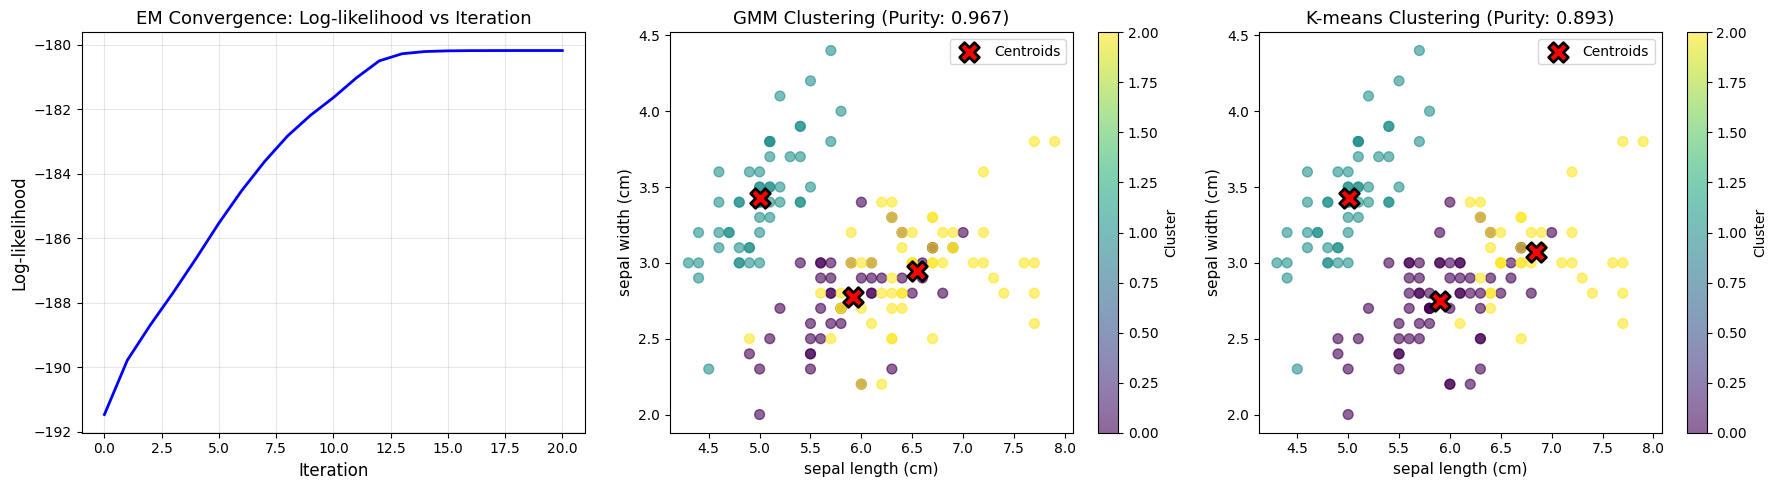

In [8]:
partB()

## **PART C**

In [9]:
class BayesianLinearRegressionEM:
    """
        Bayesian Linear Regression using the EM Algorithm
        Model:
        - Likelihood: p(y | X, w, beta) = N(y | Xw, beta^(-1)I)
        - Prior: p(w | lambda) = N(w | 0, lambda^(-1)I)
        Hyperparameters:
        - lambda: prior precision
        - beta: noise precision
    """
    def __init__(self, max_iter: int = 100, tol: float = 1e-4):
        """
            Initialize the hyperparameters and EM parameters
            Args:
                max_iter: Maximum number of EM iterations.
                tol: Convergence tolerance for log evidence change.
        """
        self.max_iter = max_iter
        self.tol = tol
        
        self.lambda_ = 1.0
        self.beta = 1.0
        
        self.mu = None
        self.Sigma = None

        # Training history
        self.log_evidences = []
        self.lambda_history = []
        self.beta_history = []
        
    def e_step(self, X: np.ndarray, y: np.ndarray):
        """
            E-step: Compute posterior distribution of weights
            Args:
                X: Input data of shape (N, D).
                y: Target data of shape (N,).
            Formula used:
                Sigma = (beta * X.T @ X + lambda * I)^(-1)
                mu = beta * Sigma @ X.T @ y
                p(w | X, y, lambda, beta) = N(w | mu, Sigma)
        """
        N, D = X.shape
        A = self.beta * (X.T @ X) + self.lambda_ * np.eye(D)
        self.Sigma = np.linalg.inv(A)
        self.mu = self.beta * (self.Sigma @ X.T @ y)
        
    def m_step(self, X: np.ndarray, y: np.ndarray):
        """
            M-step: Update hyperparameters lambda and beta
            Args:
                X: Input data of shape (N, D).
                y: Target data of shape (N,).
            Formulae used:
                lambda = D / (mu.T @ mu + trace(Sigma))
                beta = N / (||y - X @ mu||^2 + trace(X.T @ X @ Sigma))
        """
        N, D = X.shape
        residuals = y - X @ self.mu
        rss = residuals @ residuals
        uncertainty = np.trace(X.T @ X @ self.Sigma)
        self.beta = N / (rss + uncertainty)
        
    def compute_log_evidence(self, X: np.ndarray, y: np.ndarray) -> float:
        """
            Compute log marginal likelihood (evidence)
            Args:
                X: Input data of shape (N, D).
                y: Target data of shape (N,).
            Returns:
                log_evidence: The log evidence value.
            Formula used:
                logp(y | X, lambda, beta) = -0.5 * (N
        """
        N, D = X.shape
        A = self.beta * (X.T @ X) + self.lambda_ * np.eye(D)
        try:
            L = cholesky(A, lower=True)
            log_det_A = 2 * np.sum(np.log(np.diag(L)))
        except np.linalg.LinAlgError:
            log_det_A = np.linalg.slogdet(A)[1]
            
        log_det_prior = D * np.log(self.lambda_)
        
        y_term = self.beta * (y @ y) 
        mu_term = self.mu @ A @ self.mu
        
        log_evidence = -0.5 * (N * np.log(2 * np.pi) - log_det_A + log_det_prior + y_term - mu_term)
        return log_evidence
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'BayesianLinearRegressionEM':
        """
            Fit the model using the EM algorithm.
            Args:
                X: Input data of shape (N, D).
                y: Target data of shape (N,)
            Returns:
                self: The fitted Bayesian Linear Regression model.
        """
        print("Fitting Bayesian Linear Regression with EM...")
        for i in range(self.max_iter):
            self.e_step(X, y)
            self.m_step(X, y)
            self.lambda_history.append(self.lambda_)
            self.beta_history.append(self.beta)
            log_evidence = self.compute_log_evidence(X, y)
            self.log_evidences.append(log_evidence)
            if (i + 1) % 5 == 0:
                print(f"Iteration {i + 1}: | λ={self.lambda_:.4f} | β={self.beta:.4f}, | log evidence={log_evidence:.4f}")
            if i > 0:
                delta = abs(self.log_evidences[-1] - self.log_evidences[-2])
                if delta < self.tol:
                    print(f"Converged after {i + 1} iterations")
                    break
        return self
    
    def predict(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
            Precidt using the predictive distribution
            Args:
                X: Input data of shape (M, D).
            Returns:
                mean: Predictive mean of shape (M,).
                std: Predictive standard deviation of shape (M,).
            Formula used:
                p(y* | X*, X, y) = N(y* | mu.T @ X*, (1/beta + X* @ Sigma @ X*.T))
        """
        mean = X @ self.mu
        variance = 1.0 / self.beta + np.sum((X @ self.Sigma) * X, axis=1)
        std = np.sqrt(variance)
        return mean, std

In [10]:
def partC():
    print("===== PART C =====")
    np.random.seed(42)
    X_raw, y = make_regression(n_samples=500, n_features=1, noise=10.0, random_state=42)
    poly = PolynomialFeatures(degree=3, include_bias=True)
    X = poly.fit_transform(X_raw)
    print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features (polynomial degree 3)")
    print()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = BayesianLinearRegressionEM(max_iter=200)
    model.fit(X_train, y_train)
    
    print()
    print("Final hyperparameters:")
    print(f"  lambda (prior precision): {model.lambda_:.4f}")
    print(f"  beta (noise precision): {model.beta:.4f}")
    print(f"  Noise std (beta^(-1/2)): {1.0/np.sqrt(model.beta):.4f}")
    print()
    
    y_pred_train, y_std_train = model.predict(X_train)
    y_pred_test, y_std_test = model.predict(X_test)
    
    train_rmse = np.sqrt(np.mean((y_train - y_pred_train)**2))
    test_rmse = np.sqrt(np.mean((y_test - y_pred_test)**2))
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print()
    
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(model.log_evidences, 'b-', linewidth=2)
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Log Evidence', fontsize=12)
    ax1.set_title('EM Convergence: Log Marginal Likelihood', fontsize=13)
    ax1.grid(True, alpha=0.3)
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(model.lambda_history, 'r-', linewidth=2)
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('lambda (Prior Precision)', fontsize=12)
    ax2.set_title('Hyperparameter Evolution: lambda', fontsize=13)
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(model.beta_history, 'g-', linewidth=2)
    ax3.set_xlabel('Iteration', fontsize=12)
    ax3.set_ylabel('beta (Noise Precision)', fontsize=12)
    ax3.set_title('Hyperparameter Evolution: beta', fontsize=13)
    ax3.grid(True, alpha=0.3)
    
    ax4 = fig.add_subplot(gs[1, 0])
    sort_idx = np.argsort(X_train[:, 1])  
    ax4.scatter(X_train[:, 1], y_train, alpha=0.5, label='Training data')
    ax4.plot(X_train[sort_idx, 1], y_pred_train[sort_idx], 'r-', 
            linewidth=2, label='Predictions')
    ax4.fill_between(X_train[sort_idx, 1],
                     y_pred_train[sort_idx] - 2*y_std_train[sort_idx],
                     y_pred_train[sort_idx] + 2*y_std_train[sort_idx],
                     alpha=0.3, label='95% credible interval')
    ax4.set_xlabel('x', fontsize=12)
    ax4.set_ylabel('y', fontsize=12)
    ax4.set_title(f'Training Predictions (RMSE: {train_rmse:.2f})', fontsize=13)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    ax5 = fig.add_subplot(gs[1, 1])
    sort_idx_test = np.argsort(X_test[:, 1])
    ax5.scatter(X_test[:, 1], y_test, alpha=0.5, label='Test data')
    ax5.plot(X_test[sort_idx_test, 1], y_pred_test[sort_idx_test], 'r-',
            linewidth=2, label='Predictions')
    ax5.fill_between(X_test[sort_idx_test, 1],
                     y_pred_test[sort_idx_test] - 2*y_std_test[sort_idx_test],
                     y_pred_test[sort_idx_test] + 2*y_std_test[sort_idx_test],
                     alpha=0.3, label='95% credible interval')
    ax5.set_xlabel('x', fontsize=12)
    ax5.set_ylabel('y', fontsize=12)
    ax5.set_title(f'Test Predictions (RMSE: {test_rmse:.2f})', fontsize=13)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    ax6 = fig.add_subplot(gs[1, 2])
    residuals = y_test - y_pred_test
    ax6.scatter(y_pred_test, residuals, alpha=0.5)
    ax6.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax6.set_xlabel('Predicted Values', fontsize=12)
    ax6.set_ylabel('Residuals', fontsize=12)
    ax6.set_title('Residual Plot', fontsize=13)
    ax6.grid(True, alpha=0.3)
    
    plt.savefig('bayesian_lr_em_part_c.png', dpi=300, bbox_inches='tight')
    plt.show()

===== PART C =====
Dataset: 500 samples, 4 features (polynomial degree 3)

Fitting Bayesian Linear Regression with EM...
Iteration 5: | λ=1.0000 | β=0.0007, | log evidence=-616.2346
Iteration 10: | λ=1.0000 | β=0.0006, | log evidence=-624.3840
Iteration 15: | λ=1.0000 | β=0.0006, | log evidence=-624.3930
Converged after 15 iterations

Final hyperparameters:
  lambda (prior precision): 1.0000
  beta (noise precision): 0.0006
  Noise std (beta^(-1/2)): 39.9665

Training RMSE: 39.8893
Test RMSE: 39.5518



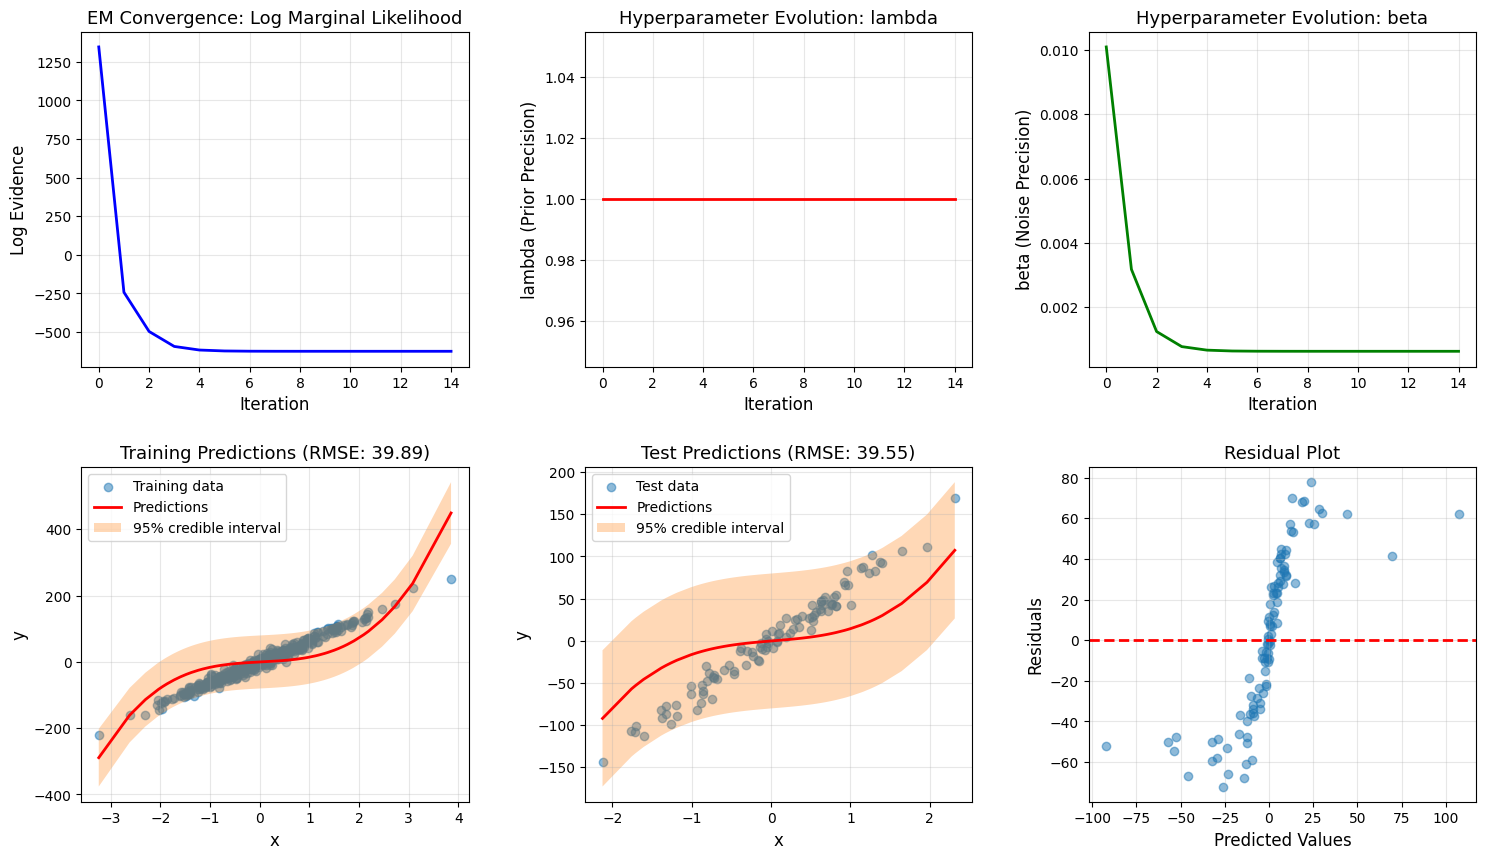

In [11]:
partC()

## **PART D**

In [12]:
class VILogisticRegression(nn.Module):
    """
        Variational Inference for Bayesian Logistic Regression
        Model:
        - Likelihood: p(y | X, w) = Bernoulli(y | sigmoid(Xw))
        - Prior: p(w) = N(w | 0, I)
        Variational Distribution:
        - q(w) = N(w | mu, diag(sigma^2))
        Uses the mean-field Gaussian approximation with reparameterization trick
        w = mu + sigma * epsilon, where epsilon ~ N(0, I)
    """
    def __init__(self, input_dim: int):
        """
            Initialize the variational parameters
            Args:
                input_dim: Dimensionality of input features (D).
        """
        super().__init__()
        self.mu = nn.Parameter(torch.zeros(input_dim))
        self.log_sigma = nn.Parameter(torch.zeros(input_dim))
        
    def forward(self, X: torch.Tensor, n_samples: int = 1) -> torch.Tensor:
        """
            Forward pass with the reparameterization trick
            Args:
                X: Input data of shape (N, D).
                n_samples: Number of weight samples to draw.
            Returns:
                logits: Logits of shape (n_samples, N).
            
            Sample weights: w = mu + sigma * epsilon, where epsilon ~ N(0, I)
            Compute logits: logits = X @ w.T
        """
        sigma = torch.exp(self.log_sigma)
        epsilon = torch.randn(n_samples, len(self.mu),  device=X.device)
        weights = self.mu + sigma * epsilon
        logits = torch.matmul(weights, X.T)
        return logits
    
    def elbo(self, X: torch.Tensor, y: torch.Tensor, n_samples: int = 10, n_data: int = None) -> torch.Tensor:
        """
            Compute the ELBO
            Args:
                X: Input data of shape (N, D).
                y: Target data of shape (N,).
                n_samples: Number of weight samples to draw.
                n_data: Total number of data points (for scaling).
            Returns:
                negative_elbo: Negative ELBO value (to minimize).
            Formulae used:
                ELBO = E_q[log p(y | X, w)] - KL(q(w) || p(w))
        """
        if n_data is None:
            n_data = len(X)
        
        logits = self.forward(X, n_samples)
        log_likelihood = -nn.functional.binary_cross_entropy_with_logits(logits, y.unsqueeze(0).expand(n_samples, -1), reduction='none')
        expected_log_likelihood = log_likelihood.mean(0).sum()
        expected_log_likelihood *= (n_data / len(X))
        sigma = torch.exp(self.log_sigma)
        kl_divergence = 0.5 * torch.sum(self.mu**2 + sigma**2 - 2*self.log_sigma - 1)
        elbo = expected_log_likelihood - kl_divergence
        return -elbo
    
    def predict_proba(self, X: torch.Tensor, n_samples: int = 100) -> torch.Tensor:
        """
            Precit probabilities by averaging over weight samples
            Args:
                X: Input data of shape (M, D).
                n_samples: Number of weight samples to draw.
            Returns:
                probs: Predicted probabilities of shape (M,).
            Formula used:
                p(y* = 1 | X*) ~~ (1 / S) sum_s sigmoid(X* @ w_s), where w_s ~ q(w)
        """
        with torch.no_grad():
            logits = self.forward(X, n_samples)
            probs = torch.sigmoid(logits)
            return probs.mean(0)

In [13]:
def trainVI(model: VILogisticRegression, X_train:torch.Tensor, y_train: torch.Tensor,
            X_val: torch.Tensor, y_val: torch.Tensor, n_epochs: int = 1000,
            lr: float = 0.01, n_samples: int = 10) -> dict:
    """
        Train Variational Logistic Regression using gradient ascent on ELBO
        Args:
            model: VILogisticRegression model.
            X_train: Training input data of shape (N_train, D).
            y_train: Training target data of shape (N_train,).
            X_val: Validation input data of shape (N_val, D).
            y_val: Validation target data of shape (N_val,).
            n_epochs: Number of training epochs.
            lr: Learning rate for the optimizer.
            n_samples: Number of weight samples to draw for ELBO estimation.
        Returns:
            history: Dictionary containing training and validation ELBO and accuracy over epochs.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {
        'train_elbo': [],
        'val_elbo': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        
        loss = model.elbo(X_train, y_train, n_samples=n_samples)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                train_elbo = -loss.item()
                train_probs = model.predict_proba(X_train, n_samples=100)
                train_preds = (train_probs > 0.5).float()
                train_acc = (train_preds == y_train).float().mean().item()
                
                val_loss = model.elbo(X_val, y_val, n_samples=n_samples)
                val_elbo = -val_loss.item()
                val_probs = model.predict_proba(X_val, n_samples=100)
                val_preds = (val_probs > 0.5).float()
                val_acc = (val_preds == y_val).float().mean().item()
                
                history['train_elbo'].append(train_elbo)
                history['val_elbo'].append(val_elbo)
                history['train_acc'].append(train_acc)
                history['val_acc'].append(val_acc)
                
                print(f"Epoch {epoch+1:4d}: "
                      f"Train ELBO={train_elbo:8.2f}, Acc={train_acc:.4f} | "
                      f"Val ELBO={val_elbo:8.2f}, Acc={val_acc:.4f}")
        
    return history

In [14]:
def partD():
    print("===== PART D =====")
    digits = load_digits()
    X_all = digits.data
    y_all = digits.target
    
    binary_mask = y_all < 5
    y_binary = binary_mask.astype(np.float32)
    
    print(f"Dataset: {len(X_all)} samples, {X_all.shape[1]} features")
    print(f"Binary classification: {y_binary.sum():.0f} class 0, "
          f"{len(y_binary) - y_binary.sum():.0f} class 1")
    print()
    
    X_normalized = (X_all - X_all.mean(0)) / (X_all.std(0) + 1e-8)
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    print(f"Train: {len(X_train)} samples")
    print(f"Val: {len(X_val)} samples")
    print(f"Test: {len(X_test)} samples")
    print()
    
    X_train_torch = torch.FloatTensor(X_train)
    y_train_torch = torch.FloatTensor(y_train)
    X_val_torch = torch.FloatTensor(X_val)
    y_val_torch = torch.FloatTensor(y_val)
    X_test_torch = torch.FloatTensor(X_test)
    y_test_torch = torch.FloatTensor(y_test)
    
    print("Training Variational Inference Logistic Regression...")
    vi_model = VILogisticRegression(input_dim=X_train.shape[1])
    history = trainVI(vi_model, X_train_torch, y_train_torch, 
                      X_val_torch, y_val_torch, n_epochs=1000, lr=0.01, n_samples=100)
    print()
    
    vi_model.eval()
    with torch.no_grad():
        vi_probs = vi_model.predict_proba(X_test_torch, n_samples=100).cpu().numpy()
        vi_preds = (vi_probs > 0.5).astype(int)
        vi_acc = accuracy_score(y_test, vi_preds)
        vi_brier = brier_score_loss(y_test, vi_probs)
        
    print("Variational Logistic Regression (Test Set):")
    print(f"  Accuracy: {vi_acc:.4f}")
    print(f"  Brier Score: {vi_brier:.4f} (lower is better)")
    print()
    
    print("Training MAP Logistic Regression (sklearn)...")
    map_model = LogisticRegression(penalty='l2', C=1.0, random_state=42, max_iter=1000)
    map_model.fit(X_train, y_train)
    
    map_probs = map_model.predict_proba(X_test)[:, 1]
    map_preds = map_model.predict(X_test)
    map_acc = accuracy_score(y_test, map_preds)
    map_brier = brier_score_loss(y_test, map_probs)
    
    print("MAP Logistic Regression (Test Set):")
    print(f"  Accuracy: {map_acc:.4f}")
    print(f"  Brier Score: {map_brier:.4f} (lower is better)")
    print()
    
    print("Comparison:")
    print(f"  VI advantage in accuracy: {(vi_acc - map_acc)*100:.2f}%")
    print(f"  VI advantage in calibration: {(map_brier - vi_brier):.4f} (Brier score)")
    print()
    
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    epochs_plot = np.arange(1, len(history['train_elbo'])+1) * 50
    ax1.plot(epochs_plot, history['train_elbo'], 'b-', linewidth=2, label='Train')
    ax1.plot(epochs_plot, history['val_elbo'], 'r--', linewidth=2, label='Validation')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('ELBO', fontsize=12)
    ax1.set_title('VI Convergence: ELBO vs Epoch', fontsize=13)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(epochs_plot, history['train_acc'], 'b-', linewidth=2, label='Train')
    ax2.plot(epochs_plot, history['val_acc'], 'r--', linewidth=2, label='Validation')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('VI Training: Accuracy vs Epoch', fontsize=13)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(gs[0, 2])
    with torch.no_grad():
        mu_vals = vi_model.mu.numpy()
        sigma_vals = torch.exp(vi_model.log_sigma).numpy()
    
    feature_idx = np.arange(len(mu_vals))
    ax3.errorbar(feature_idx, mu_vals, yerr=2*sigma_vals, fmt='o', 
                capsize=3, capthick=1, markersize=4, alpha=0.6)
    ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax3.set_xlabel('Feature Index', fontsize=12)
    ax3.set_ylabel('Weight Value', fontsize=12)
    ax3.set_title('Learned Weights (mu ± 2*sigma)', fontsize=13)
    ax3.grid(True, alpha=0.3)
    
    ax4 = fig.add_subplot(gs[1, 0])
    
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    vi_empirical = np.zeros(n_bins)
    map_empirical = np.zeros(n_bins)
    vi_counts = np.zeros(n_bins)
    map_counts = np.zeros(n_bins)
    
    for i in range(n_bins):
        mask_vi = (vi_probs >= bin_edges[i]) & (vi_probs < bin_edges[i+1])
        if mask_vi.sum() > 0:
            vi_empirical[i] = y_test[mask_vi].mean()
            vi_counts[i] = mask_vi.sum()
        
        mask_map = (map_probs >= bin_edges[i]) & (map_probs < bin_edges[i+1])
        if mask_map.sum() > 0:
            map_empirical[i] = y_test[mask_map].mean()
            map_counts[i] = mask_map.sum()
    
    ax4.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')
    ax4.plot(bin_centers, vi_empirical, 'bo-', linewidth=2, 
            markersize=8, label='VI Model')
    ax4.plot(bin_centers, map_empirical, 'rs-', linewidth=2, 
            markersize=8, label='MAP Model')
    ax4.set_xlabel('Predicted Probability', fontsize=12)
    ax4.set_ylabel('Empirical Probability', fontsize=12)
    ax4.set_title('Calibration Plot (Reliability Diagram)', fontsize=13)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim([0, 1])
    ax4.set_ylim([0, 1])
    
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.hist(vi_probs, bins=30, alpha=0.5, label='VI Model', color='blue', density=True)
    ax5.hist(map_probs, bins=30, alpha=0.5, label='MAP Model', color='red', density=True)
    ax5.set_xlabel('Predicted Probability', fontsize=12)
    ax5.set_ylabel('Density', fontsize=12)
    ax5.set_title('Distribution of Predicted Probabilities', fontsize=13)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    ax6 = fig.add_subplot(gs[1, 2])
    
    from sklearn.metrics import confusion_matrix
    vi_cm = confusion_matrix(y_test, vi_preds)
    map_cm = confusion_matrix(y_test, map_preds)
    
    comparison_text = f"""
    VI Model:
    Accuracy: {vi_acc:.4f}
    Brier Score: {vi_brier:.4f}
    
    Confusion Matrix:
    [[{vi_cm[0,0]:3d}  {vi_cm[0,1]:3d}]
     [{vi_cm[1,0]:3d}  {vi_cm[1,1]:3d}]]
    
    MAP Model:
    Accuracy: {map_acc:.4f}
    Brier Score: {map_brier:.4f}
    
    Confusion Matrix:
    [[{map_cm[0,0]:3d}  {map_cm[0,1]:3d}]
     [{map_cm[1,0]:3d}  {map_cm[1,1]:3d}]]
    """
    
    ax6.text(0.1, 0.5, comparison_text, fontsize=11, 
            family='monospace', verticalalignment='center')
    ax6.axis('off')
    ax6.set_title('Model Comparison Summary', fontsize=13)
    
    plt.savefig('variational_inference_part_d.png', dpi=300, bbox_inches='tight')
    plt.show()
    

===== PART D =====
Dataset: 1797 samples, 64 features
Binary classification: 901 class 0, 896 class 1

Train: 1149 samples
Val: 288 samples
Test: 360 samples

Training Variational Inference Logistic Regression...
Epoch  100: Train ELBO= -865.06, Acc=0.8668 | Val ELBO= -226.01, Acc=0.8229
Epoch  200: Train ELBO= -568.16, Acc=0.8930 | Val ELBO= -178.30, Acc=0.8785
Epoch  300: Train ELBO= -483.65, Acc=0.9008 | Val ELBO= -165.71, Acc=0.8889
Epoch  400: Train ELBO= -462.02, Acc=0.9043 | Val ELBO= -168.37, Acc=0.8854
Epoch  500: Train ELBO= -449.66, Acc=0.9017 | Val ELBO= -168.74, Acc=0.9028
Epoch  600: Train ELBO= -438.59, Acc=0.9077 | Val ELBO= -170.62, Acc=0.8958
Epoch  700: Train ELBO= -432.01, Acc=0.9060 | Val ELBO= -173.13, Acc=0.8958
Epoch  800: Train ELBO= -427.73, Acc=0.9086 | Val ELBO= -174.25, Acc=0.8958
Epoch  900: Train ELBO= -426.40, Acc=0.9060 | Val ELBO= -175.87, Acc=0.8924
Epoch 1000: Train ELBO= -425.42, Acc=0.9086 | Val ELBO= -175.16, Acc=0.8993

Variational Logistic Regre

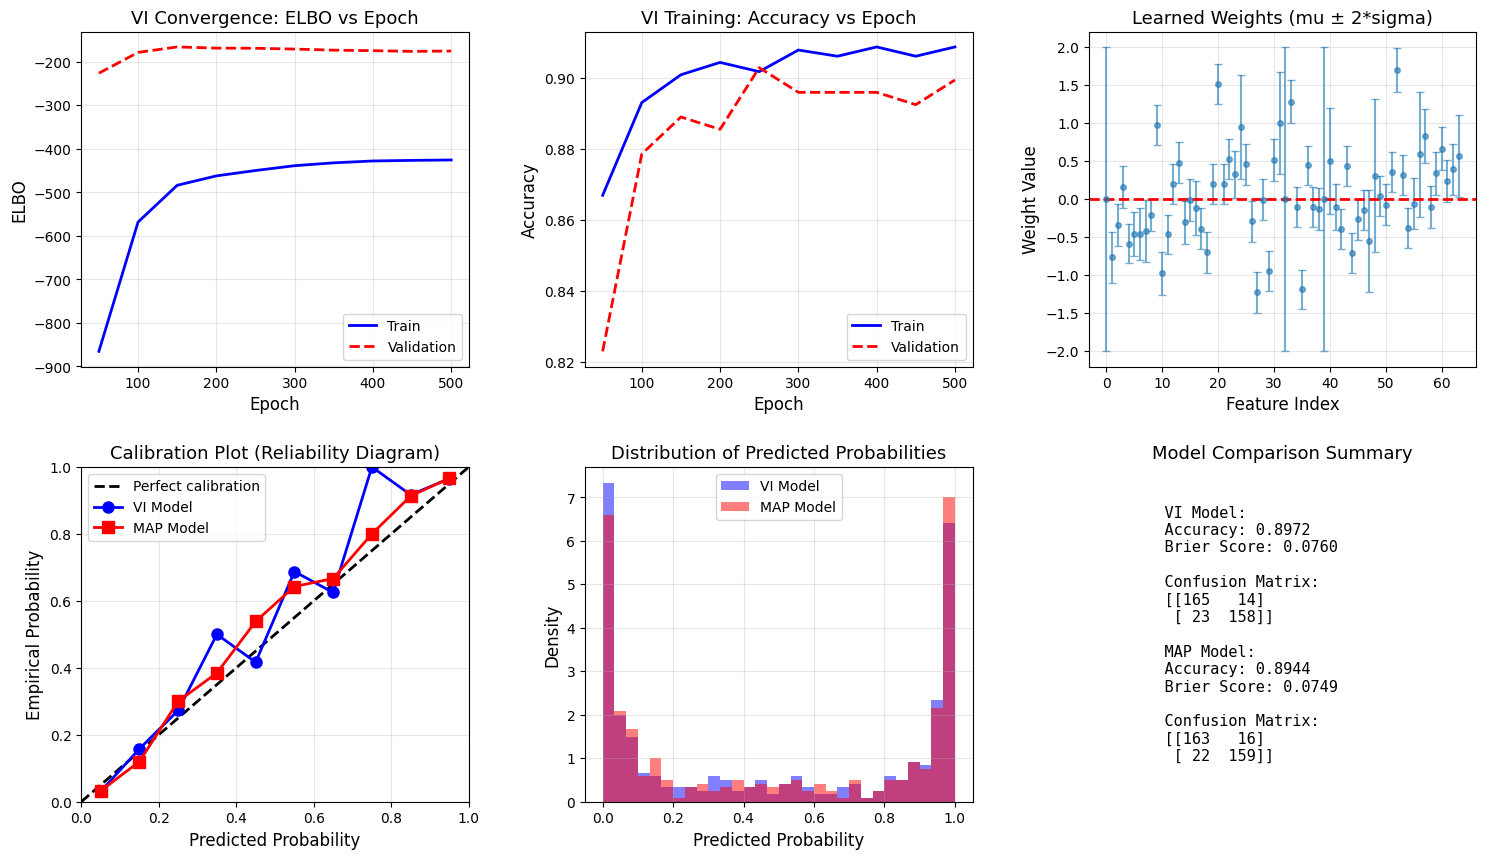

In [15]:
partD()